# 0. Load Dependencies

In [1]:
### Import the vulnerability toolkit library
import sys
repoDir = 'C:/Users/Moayad/Documents/GitHub/stickModel'
sys.path.insert(1, f'{repoDir}')
from stickModel import stickModel
from calibration import *
from utils import *
from units import *
from postprocessors import *
from plotters import *
from im_calculator import *

### Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Initialise the time
start_time = time.time()

# 1. User Input

In [2]:
### Define Capacity Curves Directory
capCurvesDir= f'{repoDir}/raw/ip-capacities'

### Define Building Class
currentBuildingClass='CR_LFINF+CDM+DUM_H4'

### Define Ground-Motion Records Directory
gmrsDir = f'{repoDir}/examples/records'

### Define Output Directory
outDir = f'{repoDir}/examples/'

# 2. Prepare the Model

HystereticSM: multi-point envelope + DCR recorders  - Code by Silvia Mazzoni, 2023 (silviamazzoni@yahoo.com) 

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance


Assumed Mode-Shape: [0.08333333 0.16666667 0.25       0.33333333 0.41666667 0.5
 0.58333333 0.66666667 0.75       0.83333333 0.91666667 1.        ]
Floor Mass: 0.15384615384615385
Elastic Stiffness of 1-th Storey: 2912.2080317899713
Elastic Stiffness of 2-th Storey: 1456.1040158949857
Elastic Stiffness of 3-th Storey: 970.736010596657
Elastic Stiffness of 4-th Storey: 728.0520079474928
Elastic Stiffness of 5-th Storey: 582.4416063579944
Elastic Stiffness of 6-th Storey: 485.3680052983286
Elastic Stiffness of 7-th Storey: 416.02971882713865
Elastic Stiffness of 8-th Storey: 364.0260039737464
Elastic Stiffness of 9-th Storey: 323.5786701988857
Elastic Stiffness of 10-th Storey: 291.2208031789971
Elastic Stiffness of 11-th Storey: 264.7461847081792
Elastic Stiffness of 12-th Storey: 242.68400264916426


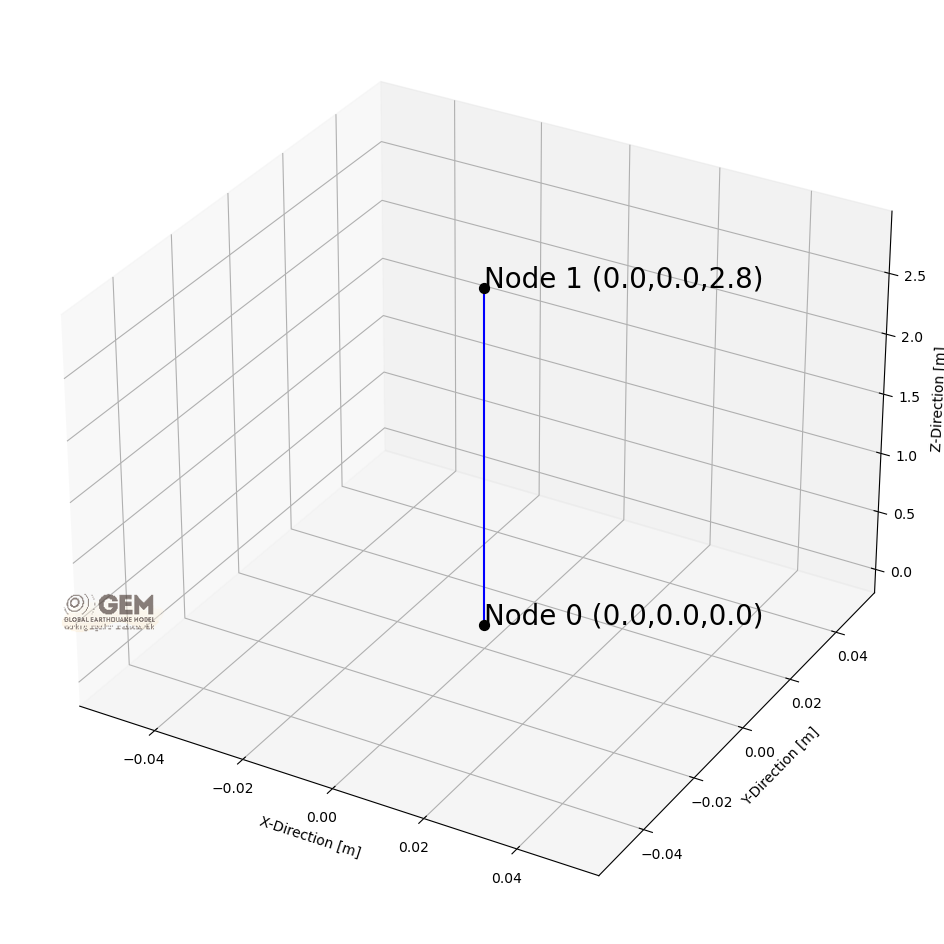

Fundamental Period:  T = 0.548 s

------ Static Pushover Analysis of Node # 1 to 1.0 ---------
Currently pushed node 1 to 0.005 with 0.6572691738414868
Currently pushed node 1 to 0.01 with 1.3145383476829735
Currently pushed node 1 to 0.015 with 1.9718075215244601
Currently pushed node 1 to 0.02 with 2.5051345082986956
Currently pushed node 1 to 0.025 with 2.599030104561765
Currently pushed node 1 to 0.030000000000000002 with 2.6929257008248344
Currently pushed node 1 to 0.035 with 2.7868212970879043
Currently pushed node 1 to 0.04 with 2.8807168933509737
Currently pushed node 1 to 0.045 with 2.974612489614043
Currently pushed node 1 to 0.049999999999999996 with 3.0685080858771125
Currently pushed node 1 to 0.05499999999999999 with 3.1624036821401824
Currently pushed node 1 to 0.05999999999999999 with 3.256299278403252
Currently pushed node 1 to 0.06499999999999999 with 3.3501948746663213
Currently pushed node 1 to 0.06999999999999999 with 3.4440904709293907
Currently pushed node 1 to 

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

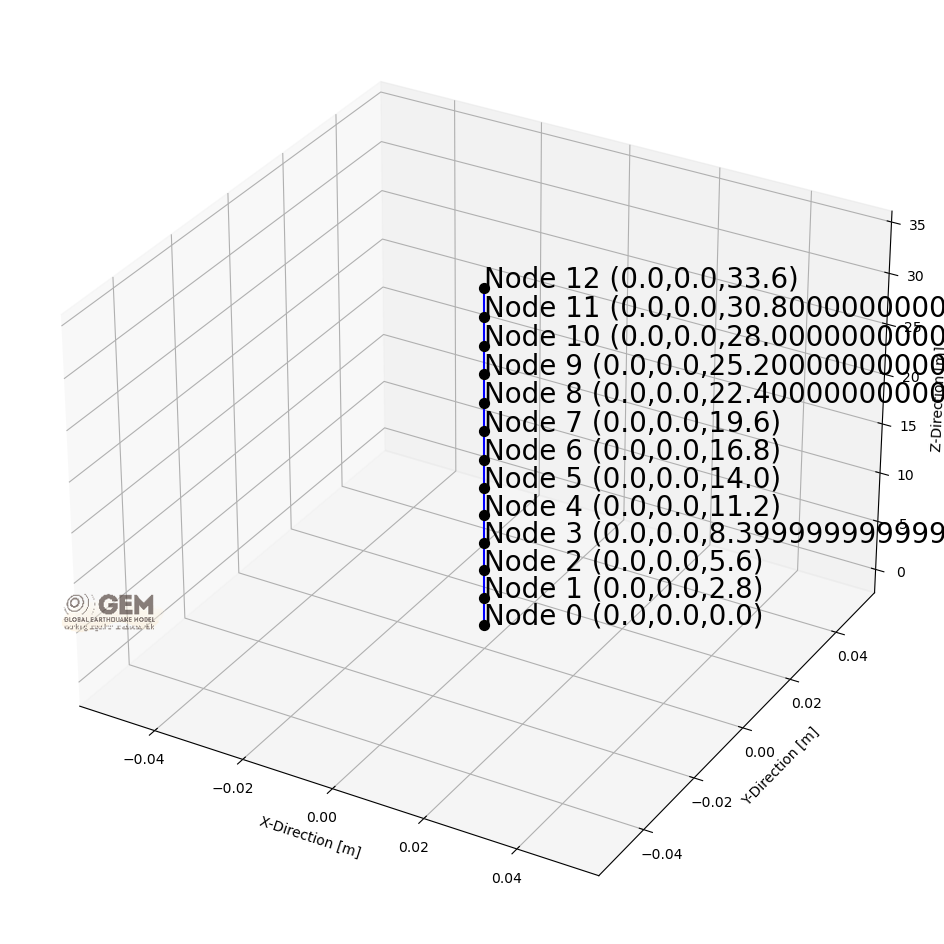

Fundamental Period:  T = 0.764 s

------ Static Pushover Analysis of Node # 12 to 0.2 ---------
Currently pushed node 12 to 0.001 with 0.011637194932227658
Currently pushed node 12 to 0.002 with 0.023274389864455316
Currently pushed node 12 to 0.003 with 0.03491158479668297
Currently pushed node 12 to 0.004 with 0.04654877972891063
Currently pushed node 12 to 0.005 with 0.058185974661138284
Currently pushed node 12 to 0.006 with 0.06982316959336594
Currently pushed node 12 to 0.007 with 0.0814603645255936
Currently pushed node 12 to 0.008 with 0.09309755945782126
Currently pushed node 12 to 0.009000000000000001 with 0.10473475439004892
Currently pushed node 12 to 0.010000000000000002 with 0.1163719493222766
Currently pushed node 12 to 0.011000000000000003 with 0.12800914425450427
Currently pushed node 12 to 0.012000000000000004 with 0.13964633918673194
Currently pushed node 12 to 0.013000000000000005 with 0.1512835341189596
Currently pushed node 12 to 0.014000000000000005 with 0.162920

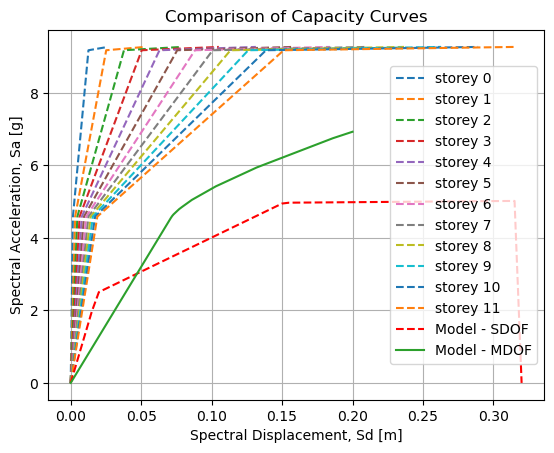

In [3]:
### Load the building class info
classInfo = pd.read_csv(f'{capCurvesDir}/in_plane_capacity_parameters_table.csv')

### Import the building class info
nst          = int(currentBuildingClass.split('H')[-1])
storeyHeight = classInfo['Storey_height'].loc[classInfo['Building_class']==currentBuildingClass].item()
flh_mdof     = [storeyHeight]*nst
gamma        = classInfo['Participation_factor'].loc[classInfo['Building_class']==currentBuildingClass].item()

### Import the equivalent SDOF capacity array 
sdofCapArray = np.array(pd.read_csv(f'{capCurvesDir}/{currentBuildingClass}.csv', header = None))[1:,:]

### Calibrate the model and get the period, masses, and strength-deformation relationships of all storeys
T, flm_mdof, stD_mdof, stF_mdof = calibrateModel(nst,gamma, sdofCapArray)

# 3. Define Analysis Objects

In [ ]:
### Fetch ground motion records
gmrs = sorted_alphanumeric(os.listdir(f'{gmDir}/gmrs'))   # Sort the ground-motion records alphanumerically

### Initialise storage lists
coll_index_list = []               # List for collapse index
peak_disp_list  = []               # List for peak floor displacement (returns all peak values along the building height)
peak_drift_list = []               # List for peak storey drift (returns all peak values along the building height)
peak_accel_list = []               # List for peak floor acceleration (returns all peak values along the building height)
max_peak_drift_list = []           # List for maximum peak storey drift (returns the maximum value) 
max_peak_drift_dir_list = []       # List for maximum peak storey drift directions
max_peak_drift_loc_list = []       # List for maximum peak storey drift locations
max_peak_accel_list = []           # List for maximum peak floor acceleration (returns the maximum value)
max_peak_accel_dir_list = []       # List for maximum peak floor acceleration directions 
max_peak_accel_loc_list = []       # List for maximum peak floor acceleration locations 
pga = [];      sa = []             # List for intensity measures

# 4. Compile the Model and Run Nonlinear Time-History Analysis

WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

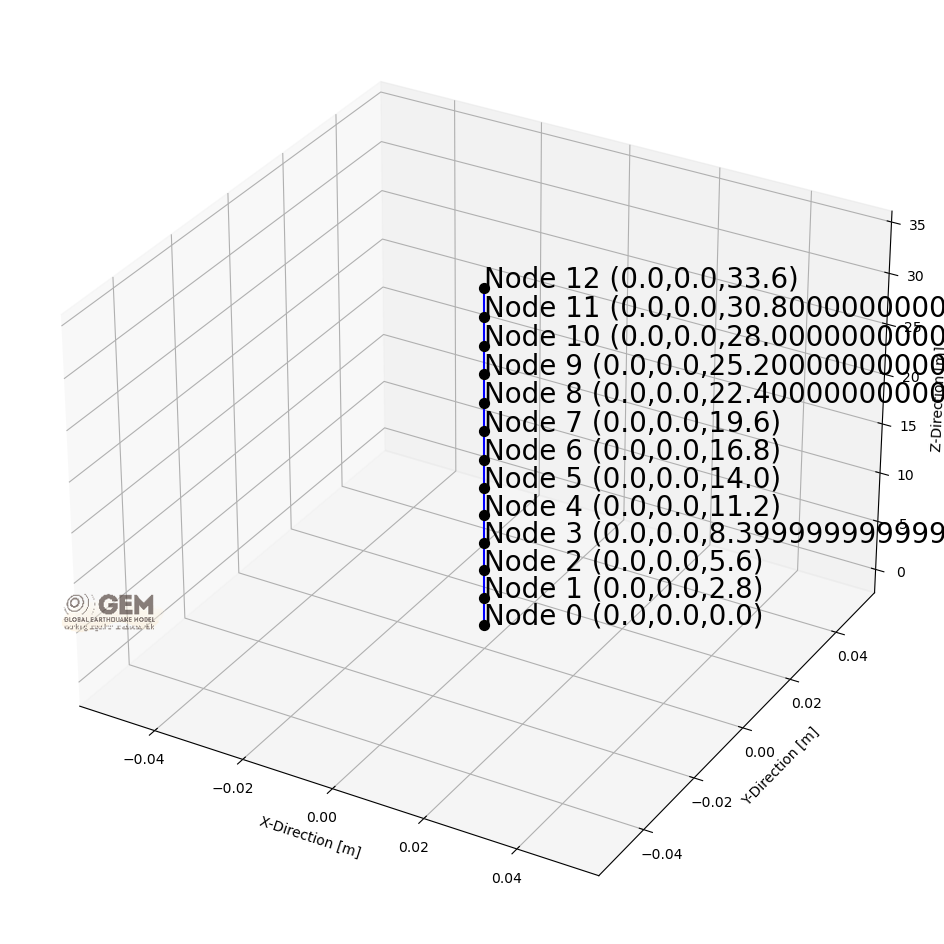

Fundamental Period:  T = 0.764 s
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 1 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 2 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 3 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 4 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 5 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 6 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 7 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 8 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 9 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 10 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 11 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 12 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 13 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 14 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 15 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 16 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 17 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 18 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 19 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 20 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 21 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 22 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 23 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 24 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 25 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 26 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 27 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 28 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 29 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 30 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 31 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 32 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 33 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 34 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 35 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 36 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 37 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 38 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 39 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 40 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 41 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 42 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 43 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 44 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 45 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 46 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 47 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 48 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 49 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 50 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 51 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 52 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 53 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 54 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 55 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 56 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 57 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 58 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 59 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 60 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 61 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 62 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 63 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 64 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 65 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 66 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 67 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 68 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 69 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 70 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 71 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 72 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 73 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 74 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 75 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 76 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 77 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 78 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 79 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 80 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 81 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 82 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 83 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 84 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 85 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 86 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 87 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 88 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 89 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 90 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 91 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 92 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 93 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 94 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 95 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 96 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 97 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 98 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 99 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 100 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 101 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 102 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 103 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 104 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 105 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 106 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 107 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 108 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 109 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 110 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

FAILED at 8.620: Trying reducing time-step in half...
~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 111 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 112 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 113 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 114 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 115 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 116 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 117 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 118 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 119 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 120 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 121 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 122 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 123 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 124 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 125 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 126 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 127 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 128 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 129 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 130 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 131 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 132 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 133 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 134 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 135 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 136 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 137 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 138 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 139 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 140 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 141 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 142 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 143 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 144 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 145 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 146 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 147 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 148 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 149 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 150 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 151 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 152 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 153 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 154 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 155 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 156 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 157 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 158 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 159 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 160 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 161 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 162 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 163 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 164 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 165 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 166 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 167 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 168 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 169 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 170 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 171 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 172 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 173 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 174 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 175 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 176 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 177 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 178 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 179 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 180 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 181 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 182 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 183 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 184 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 185 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 186 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 187 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 188 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 189 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

======= ANALYSIS STOPPED FOR STRUCTURE COLLAPSE AT STOREY 1 in X ========
============== ANALYSIS COMPLETED: 190 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 191 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 192 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 193 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 194 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 195 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 196 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 197 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 198 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 199 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 200 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 201 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 202 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 203 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 204 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 205 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 206 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 207 out 208 ==================
Fundamental Period:  T = 0.764 s


WARNING ZeroLength::setDomain(): Element 2000 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2001 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2002 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2003 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2004 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2005 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2006 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2007 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2008 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 2009 has L= 2.8, which is greater than the tolerance
WARNING ZeroLength::setDomain(): Element 20010 has L= 2.8, w

~~~~~~~ ANALYSIS SUCCESSFUL ~~~~~~~~~
============== ANALYSIS COMPLETED: 208 out 208 ==================


In [4]:
for i in range(len(gmrs)):
    
    ### Compile the SDOF model
    model = stickModel(nst,flh_mdof,flm_mdof,stD_mdof,stF_mdof)            # Build the model
    model.mdof_initialise()                                      # Initialise the domain
    model.mdof_nodes()                                           # Construct the nodes
    model.mdof_fixity()                                          # Set the boundary conditions 
    model.mdof_loads()                                           # Assign the loads
    model.mdof_material()                                        # Assign the nonlinear storey material
    if i==0:
        model.plot_model()                                       # Visualise the model
    else: 
        pass
    model.do_gravity_analysis()                                  # Do gravity analysis
    T = model.do_modal_analysis(num_modes = 1)                   # Do modal analysis and get period of vibration

    ### Define ground motion objects
    fnames = [f'{gmDir}/gmrs/{gmrs[i]}']                                # Ground-motion record names
    fdts = f'{gmDir}/dts/dts_{i}.csv'                                   # Ground-motion time-step names 
    dt_gm = pd.read_csv(fdts)[pd.read_csv(fdts).columns[0]].loc[0]      # Ground-motion time-step
    t_max = pd.read_csv(fdts)[pd.read_csv(fdts).columns[0]].iloc[-1]    # Ground-motion duration

    ### Get intensity measures
    im = intensityMeasure(pd.read_csv(fnames[0]).to_numpy().flatten(),dt_gm) # Initialise the intensityMeasure object
    pga.append(im.get_sa(0.0))                                               # Append PGA values 
    sa.append(im.get_sa(T[0]))                                               # Append Sa(T1) values
    
    ### Define analysis params and do NLTHA
    dt_ansys = dt_gm                                                         # Set the analysis time-step
    sf = units.g                                                             # Set the scaling factor (if records are in g, a scaling factor of 9.81 m/s2 must be used to be consistent with opensees) 
    collLimit = 10.00                                                        # Set a large number for numerical collapse
    control_nodes, coll_index, peak_drift, peak_accel, max_peak_drift, max_peak_drift_dir, max_peak_drift_loc, max_peak_accel, max_peak_accel_dir, max_peak_accel_loc, peak_disp = model.do_nrha_analysis(fnames, dt_gm, sf, t_max, dt_ansys, collLimit, outDir)

    #######################            
    ### Store the analysis 
    #######################
    coll_index_list.append(coll_index)
    peak_drift_list.append(peak_drift)
    peak_accel_list.append(peak_accel)
    peak_disp_list.append(peak_disp)
    max_peak_drift_list.append(max_peak_drift)
    max_peak_drift_dir_list.append(max_peak_drift_dir)
    max_peak_drift_loc_list.append(max_peak_drift_loc)
    max_peak_accel_list.append(max_peak_accel)
    max_peak_accel_dir_list.append(max_peak_accel_dir)
    max_peak_accel_loc_list.append(max_peak_accel_loc)
    #######################

    print('================================================================')
    print('============== ANALYSIS COMPLETED: {:d} out {:d} =================='.format(i+1, len(gmrs)))
    print('================================================================')

# 5. Postprocess the Cloud Analysis

In [ ]:
### Process the cloud analysis results for PGA and SA(T1)
imvector1, edpvector1 = cloudAnalysis(pga, max_peak_drift_list) # fit the regression to PGA 
imvector2, edpvector2 = cloudAnalysis(sa,  max_peak_drift_list) # fit the regression to Sa(T1)

### Store the results
ansys_dict = {}
labels = ['T','sa','pga','imvector1','edpvector1',
          'imvector2', 'edpvector2',
          'control_nodes', 'coll_index_list',
          'peak_drift_list','peak_accel_list','max_peak_drift_list',
          'max_peak_drift_dir_list', 'max_peak_drift_loc_list','max_peak_accel_list',
          'max_peak_accel_dir_list','max_peak_accel_loc_list','peak_disp_list']

for i, label in enumerate(labels):
    ansys_dict[label] = vars()[f'{label}']
#export_to_pkl(f'{classDir}/nltha_{currentBuildingClass}.pkl', ansys_dict)

In [ ]:
### Peak Ground Acceleration
# Plot the mdof cloud and regression
plt.scatter(mdof_max_peak_drift_list, mdof_pga, alpha = 0.5)
plt.plot(mdof_edpvector1, mdof_imvector1, linewidth=8)

plt.xlabel(r'Maximum Peak Storey Drift, $\theta_{max}$ [%]')
plt.ylabel(r'Peak Ground Acceleration, PGA [g]')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor')
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-3, 1e3])
plt.show()

### Spectral Acceleration
# Plot the mdof cloud and regression
plt.scatter(mdof_max_peak_drift_list, mdof_sa, alpha = 0.5)
plt.plot(mdof_edpvector2, mdof_imvector2, linewidth=8)

plt.xlabel(r'Maximum Peak Storey Drift, $\theta_{max}$ [%]')
plt.ylabel(r'Spectral Acceleration, $Sa(T_{1})$ [g]')
plt.grid(visible=True, which='major')
plt.grid(visible=True, which='minor')
plt.xscale('log')
plt.yscale('log')
plt.ylim([5e-3, 1e3])
plt.show()

In [ ]:
# get the end time
end_time = time.time()
# get the execution time
elapsed_time = end_time - start_time
print('Execution time:', elapsed_time, 'seconds')